In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

import statsmodels as stat
from statsmodels.tsa.stattools import adfuller

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 

from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import LSTM, Dense

In [2]:
#Lectura de data
data = pd.read_csv('./perrin-freres-monthly-champagne-.csv')

In [3]:
#visulizacion data
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [306]:
data.tail(3)

,Month,Sales,Sales diff,Forecast,Forecast_s
103,1972-08-01,1413.0,-246.0,5062.47444,1936.389489
104,1972-09-01,5877.0,-74.0,NaN,6061.736825
105,NaT,NaN,NaN,NaN,7112.332355


In [4]:
# definicion nombre columnas
data.columns = ['Month','Sales']

In [5]:
#Se elimina ultima fila ya que no es represntativa y tiene nan
data.drop(106, axis=0, inplace = True)

In [6]:
# validacion tipo de data
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106 entries, 0 to 105
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Month   105 non-null    object 
 1   Sales   105 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [7]:
#se convierte la variable fecha a datetime
data.Month = pd.to_datetime(data.Month)
#verificacion del cambio de dato
data.info()

In [9]:
#distribucion de los datos en la columna Sales
data.describe()

,Sales
count,105.000000
mean,4761.152381
std,2553.502601
min,1413.000000
25%,3113.000000
50%,4217.000000
75%,5221.000000
max,13916.000000


<AxesSubplot:xlabel='Month', ylabel='Sales'>

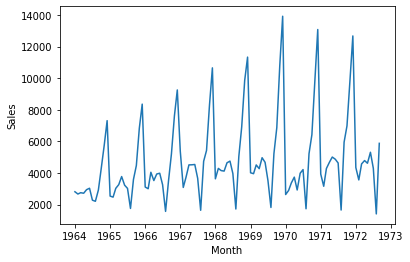

In [309]:
# Visualizacion de ventas en el tiempo 
sns.lineplot(data = data, x= 'Month', y = 'Sales')

In [312]:
# Prueba de estacioneridad
#Ho: Es no estacionaria 
#H1: Es estacionaria

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test estadistico','p-value','#Lags Usadas','Numero de observaciones usadas']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("evidencia fuerte contra la hipótesis nula(Ho), rechazar la hipótesis nula. Los datos no tienen raíz unitaria y son estacionarios")
    else:
        print("evidencia débil contra la hipótesis nula, la serie temporal tiene una raíz unitaria, lo que indica que es no estacionaria")

In [313]:
adfuller_test(data['Sales'])

ADF Test estadistico : nan
p-value : nan
#Lags Usadas : 0
Numero de observaciones usadas : 105
evidencia débil contra la hipótesis nula, la serie temporal tiene una raíz unitaria, lo que indica que es no estacionaria


In [314]:
#desfasa 12 meses con el fin de volverlo estacionario 
data['Sales diff']= data['Sales'] - data['Sales'].shift(12) 

In [315]:
# data estacionaria
adfuller_test(data['Sales diff'].dropna())

ADF Test estadistico : -7.626619157213164
p-value : 2.060579696813685e-11
#Lags Usadas : 0
Numero de observaciones usadas : 92
evidencia fuerte contra la hipótesis nula(Ho), rechazar la hipótesis nula. Los datos no tienen raíz unitaria y son estacionarios


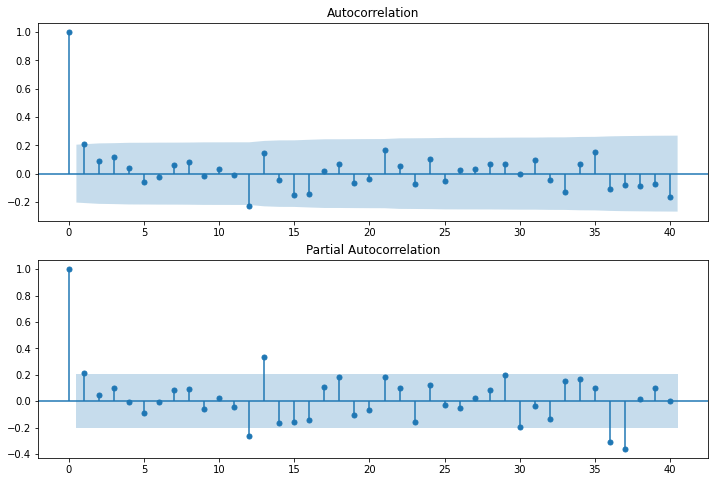

In [19]:
# visualizacion de autocorrelacion y autocorrelacion parcial de 'sales diff'
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Sales diff'].iloc[13:].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Sales diff'].iloc[13:].dropna(),lags=40,ax=ax2)

C:\Users\jonat\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


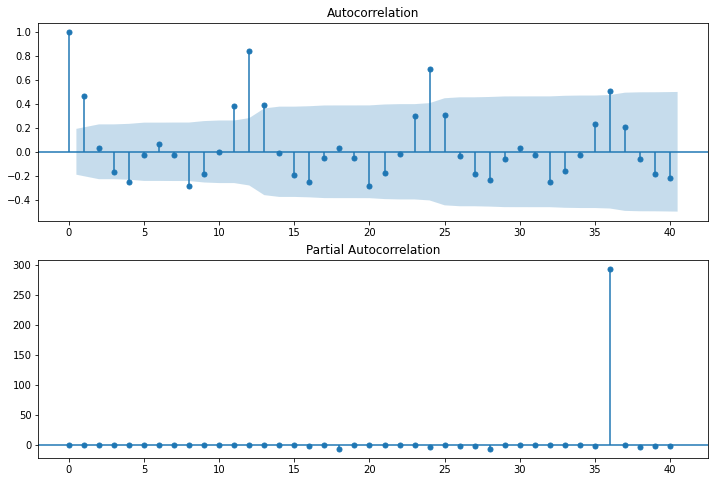

In [20]:
# visualizacion de autocorrelacion y autocorrelacion parcial de 'sales'
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(data['Sales'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(data['Sales'].dropna(),lags=40,ax=ax2)

### Modelo Arima

In [22]:
model = ARIMA(data['Sales'],order = (1,1,1))#parametros (1,1,1)(p,q,d)
model_fit= model.fit()

<AxesSubplot:>

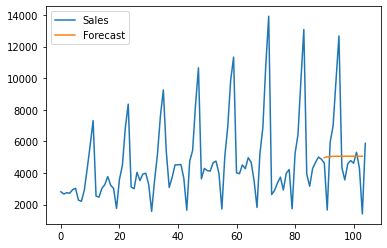

In [25]:
# forecast modelo ARIMA
data['Forecast'] = model_fit.predict(start = 90, end = 103 , dynamic = True)
data[['Sales', 'Forecast']].plot()

### Modelo SARIMAX

In [27]:
model_ciclico = sm.tsa.statespace.SARIMAX(data['Sales'],order = (1,1,1), seasonal_order = (1,1,1,12))
model_ciclico_fit = model_ciclico.fit()

<AxesSubplot:>

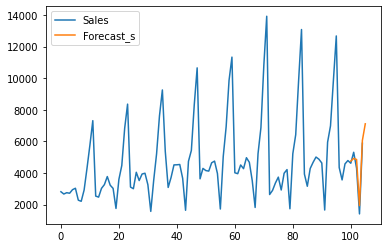

In [28]:
data['Forecast_s'] = model_ciclico_fit.predict(start = 100, end = 130 , dynamic = True)
data[['Sales', 'Forecast_s']].plot()

In [29]:
data

,Month,Sales,Sales diff,Forecast,Forecast_s
0,1964-01-01,2815.0,NaN,NaN,NaN
1,1964-02-01,2672.0,NaN,NaN,NaN
2,1964-03-01,2755.0,NaN,NaN,NaN
3,1964-04-01,2721.0,NaN,NaN,NaN
4,1964-05-01,2946.0,NaN,NaN,NaN
...,...,...,...,...,...
101,1972-06-01,5312.0,438.0,5062.462814,4925.390241
102,1972-07-01,4298.0,-335.0,5062.470807,4854.991783
103,1972-08-01,1413.0,-246.0,5062.474440,1936.389489
104,1972-09-01,5877.0,-74.0,NaN,6061.736825


### MODELO CON RNN LSTM

In [320]:
# se dividen datos
training_set = df.iloc[:80,1:2]
test_set = df.iloc[80:,1:2]

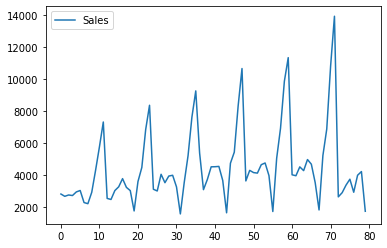

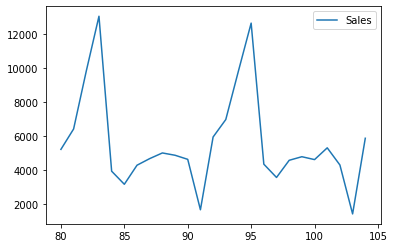

In [321]:
# Visualizacion de data train y test
training_set.plot(legend=True)
test_set.plot(legend=True)
plt.show()

In [322]:
# Normalizacion de caracteristica Sales
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
# Dimension de los datos escalados
training_set_scaled.shape

(80, 1)

In [323]:
# Usamos el bloque for para iterar dividir el set de entrenamiento en 
#bloques de 7 datos y almacenar los bloques correspondientes en diferentes posiciones de las variables X_train y Y_train
time_step = 7
X_train = []
Y_train = []
m = len(training_set_scaled)

for i in range(time_step,m):
    # X: bloques de "time_step" datos: 0-time_step, 1-time_step+1, 2-time_step+2, etc
    X_train.append(training_set_scaled[i-time_step:i,0])

    # Y: el siguiente dato
    Y_train.append(training_set_scaled[i,0])
    
X_train, Y_train = np.array(X_train), np.array(Y_train)
print(X_train.shape)

(73, 7)


In [324]:
# Se ajusta la dimension de los datos antes de ingresar a LSTM 
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)

(73, 7, 1)


In [325]:
# Creacion del modelo Long short-term memory 
#Se definen caracteristicas de la red tama;o de in, output y  
dim_entrada = (X_train.shape[1],1)
dim_salida = 1
na = 50

#contenedor
modelo = Sequential()
modelo.add(LSTM(units=na, input_shape=dim_entrada))
modelo.add(Dense(units=dim_salida))

modelo.compile(optimizer='rmsprop', loss='mse')

In [326]:
#El entrenamiento se implementa usando la función fit.
#Se definen 10 iteraciones (parámetro epochs) y presentaremos a la Red LSTM lotes de 15 dato
modelo.fit(X_train,Y_train,epochs=10,batch_size=15)

Epoch 1/10
5/5 [==============================] - 2s 6ms/step - loss: 0.0706
Epoch 2/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0459
Epoch 3/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0483
Epoch 4/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0388
Epoch 5/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0369
Epoch 6/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0357
Epoch 7/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0407
Epoch 8/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0410
Epoch 9/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0461
Epoch 10/10
5/5 [==============================] - 0s 5ms/step - loss: 0.0394


In [327]:
#Se reorganizaa el set de validación (x_test) 
dataset_train = df.iloc[:80,1:2]
dataset_test = df.iloc[80:,1:2]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 8:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

In [328]:
inputs.shape, dataset_total.shape, dataset_test.shape

((34, 1), (106, 1), (26, 1))

In [329]:
X_prueba = []
for i in range(8,34):
    X_prueba.append(inputs[i-8:i, 0])
    
X_prueba = np.array(X_prueba)
X_prueba = np.reshape(X_prueba, (X_prueba.shape[0], X_prueba.shape[1], 1))

print(X_prueba.shape)

(26, 8, 1)


In [330]:
forecast_LSTM = modelo.predict(X_prueba)
forecastLSTM = sc.inverse_transform(forecast_LSTM)

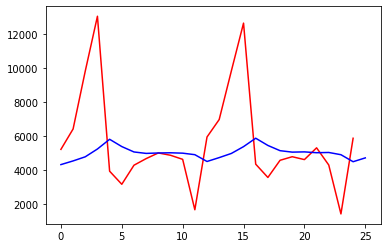

In [331]:
# Visualizacion de los resultados
plt.plot(dataset_test.values, color = 'red', label = 'Real sales champagne')
plt.plot(forecastLSTM , color ='blue', label = 'Predicted sales')

plt.show()